In [1]:
from customize_minigrid.custom_env import CustomEnv
import matplotlib.pyplot as plt
import numpy as np
from mdp_learner import OneHotEncodingMDPLearner
from customize_minigrid.wrappers import FullyObsSB3MLPWrapper
from mdp_graph.mdp_graph import MDPGraph, PolicyGraph, OptimalPolicyGraph

pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


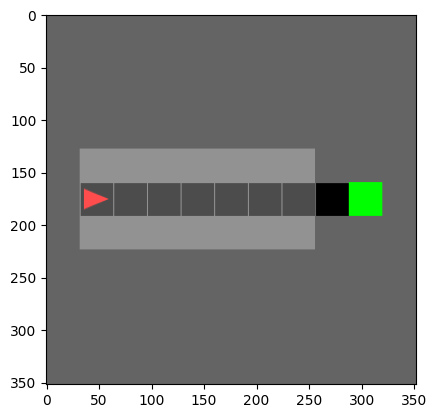

In [2]:
file_path = 'maps/extra_long_corridor.txt'
env = CustomEnv(
        txt_file_path=file_path,
        display_size=11,
        display_mode="middle",
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        random_rotate=False,
        random_flip=False,
        custom_mission="Find the key and open the door.",
        render_mode=None,
    )
env.reset()
img = env.get_frame(env.highlight, env.tile_size, env.agent_pov)
plt.imshow(img)
plt.show()

In [3]:
env = FullyObsSB3MLPWrapper(env, to_print=False)
learner = OneHotEncodingMDPLearner(env)
learner.learn()

C:\Users\13769\anaconda3\envs\mini-grid-generation\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\13769\anaconda3\envs\mini-grid-generation\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\13769\anaconda3\envs\mini-grid-generation\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


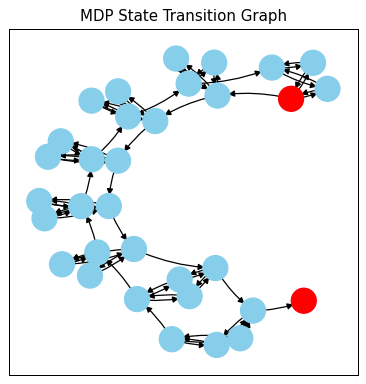

In [4]:
optimal_graph = OptimalPolicyGraph()
optimal_graph.load_graph(learner.mdp_graph)
optimal_graph.uniform_prior_policy()
optimal_graph.visualize(highlight_states=[learner.start_state, *learner.done_states], use_grid_layout=False, display_state_name=False)

In [5]:
optimal_graph.optimal_value_iteration(0.999, threshold=1e-5)
optimal_graph.compute_optimal_policy(0.999, threshold=1e-5)
optimal_graph.control_info_iteration(1.0, threshold=1e-5)
optimal_graph.value_iteration(1.0, threshold=1e-5)

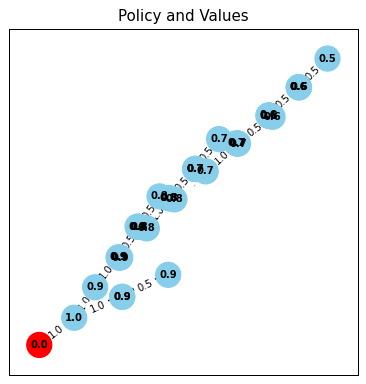

In [6]:
optimal_graph.visualize_policy_and_values(title="Policy and Values", value_type="value",
                                              highlight_states=[learner.start_state, *learner.done_states],
                                              use_grid_layout=False, display_state_name=False)

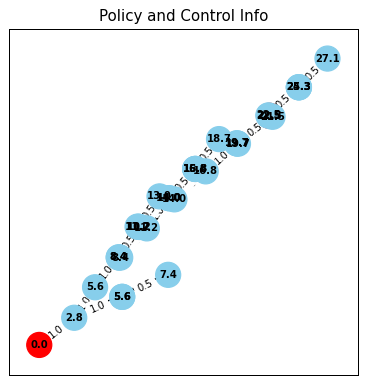

In [7]:
optimal_graph.visualize_policy_and_values(title="Policy and Control Info", 
                                          value_type="control_info",
                                          highlight_states=[learner.start_state, *learner.done_states],
                                          use_grid_layout=False, display_state_name=False)

In [8]:
import torch
from binary_state_representation.binary2binaryautoencoder import Binary2BinaryFeatureNet
from minigrid_abstract_encoding import EncodingMDPLearner


device = "cuda" if torch.cuda.is_available() else "cpu"

NUM_ACTIONS = int(env.action_space.n)
OBS_SPACE = int(env.total_features)
LATENT_DIMS = 24
print(NUM_ACTIONS, OBS_SPACE, LATENT_DIMS)

# train hyperparams
WEIGHTS = {'inv': 1.0, 'dis': 1.0, 'neighbour': 0.0, 'dec': 0.0, 'rwd': 0.1, 'terminate': 1.0}
BATCH_SIZE = 32
LR = 1e-4

model = Binary2BinaryFeatureNet(NUM_ACTIONS, OBS_SPACE, n_latent_dims=LATENT_DIMS, lr=LR, weights=WEIGHTS, device=device, )

model.load(r'experiments/learn_feature_corridor_24/model_epoch_200.pth')
model.use_bin = True

encoder = model.encoder.to(device)

7 2575 24


D:\workspace\mini-grid-curriculum\binary_state_representation\binary2binaryautoencoder.py:556: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoi

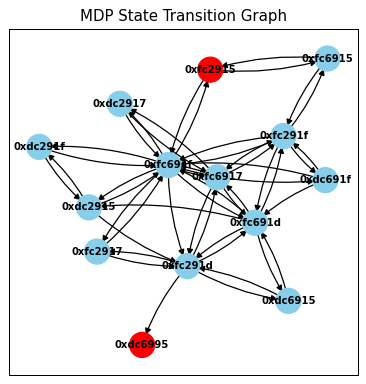

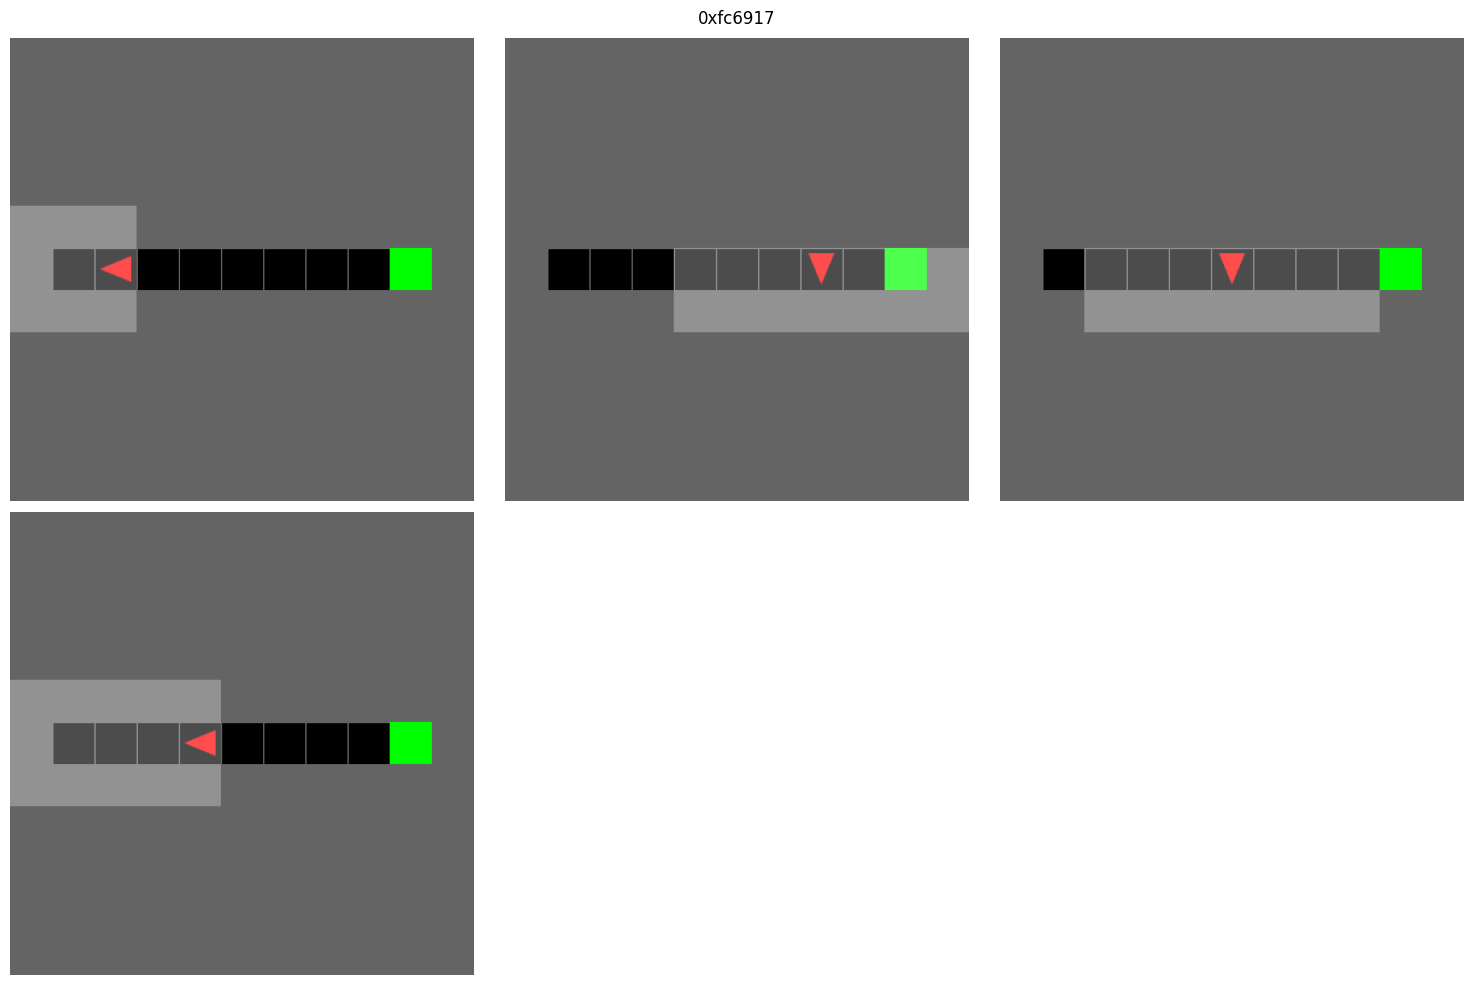

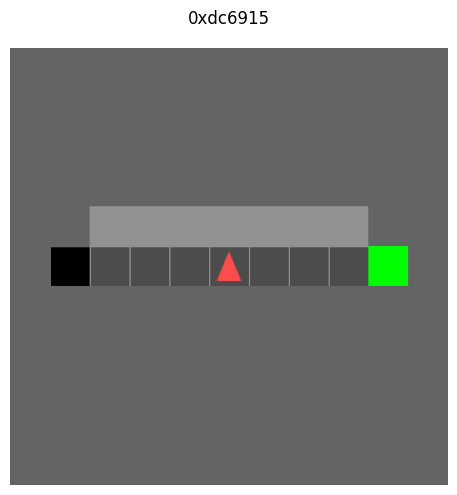

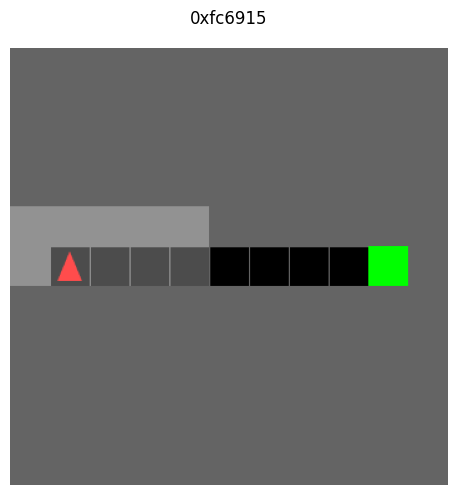

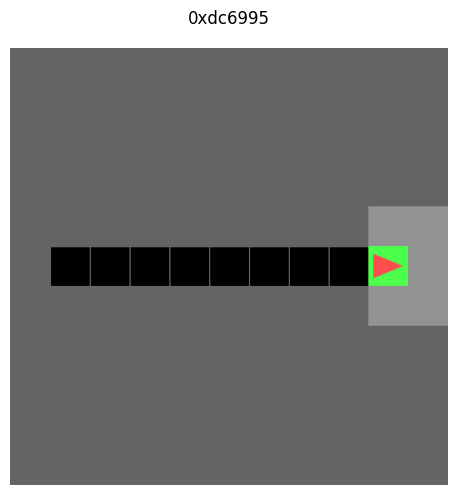

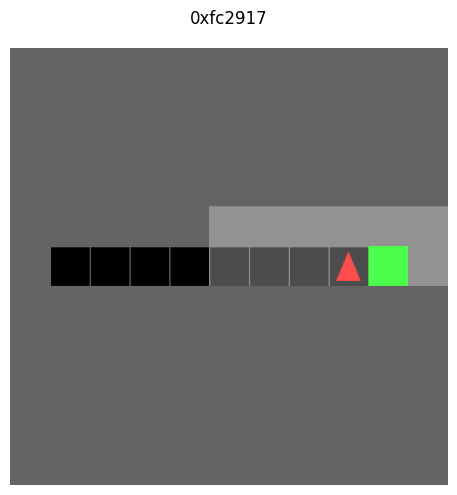

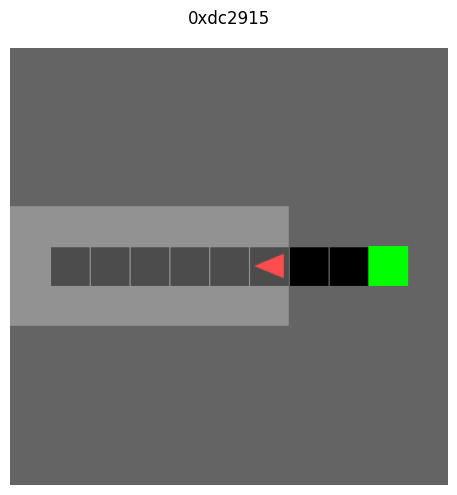

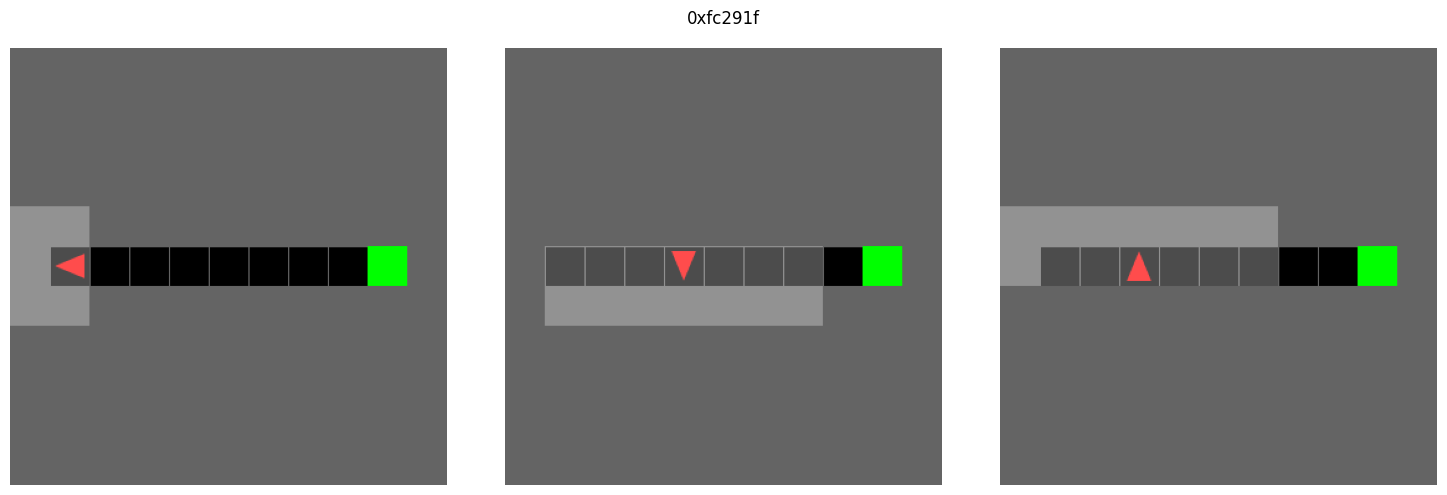

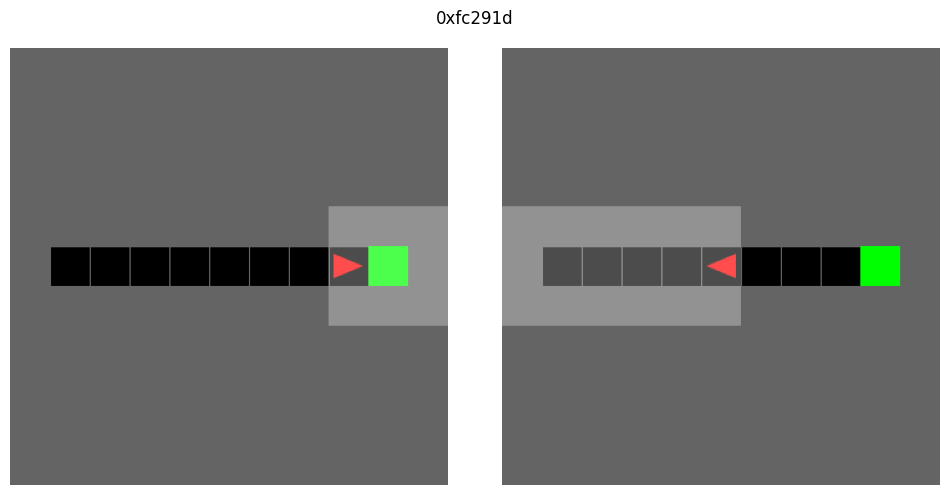

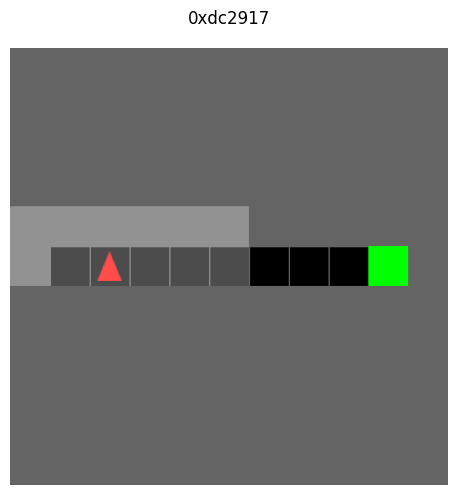

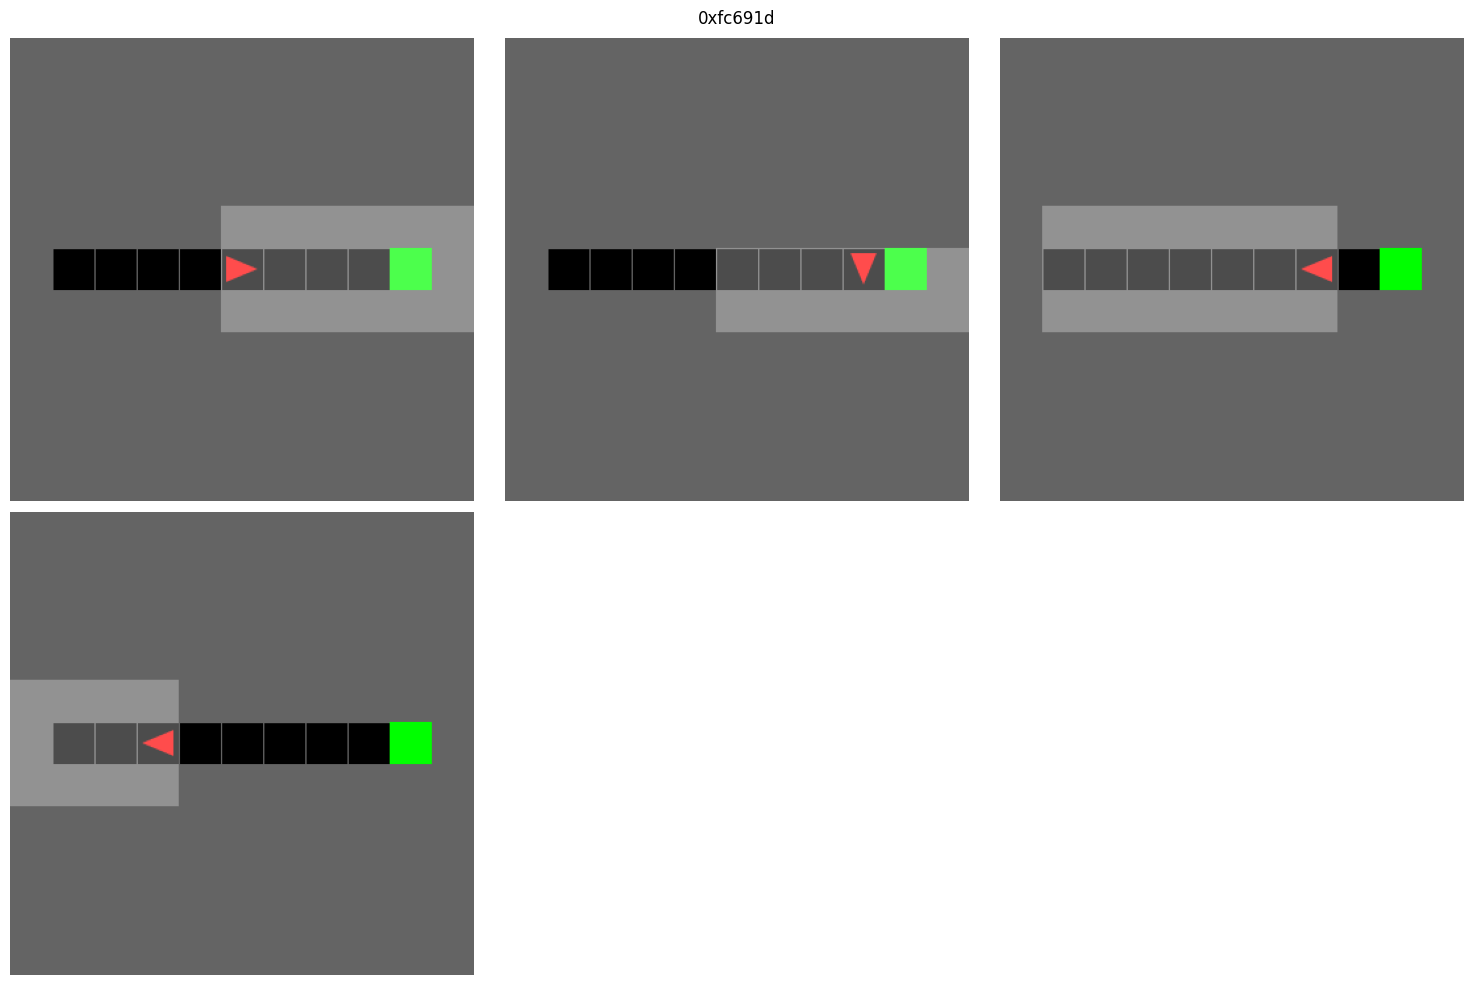

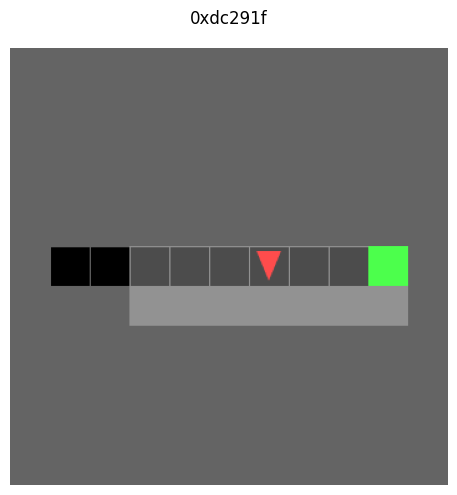

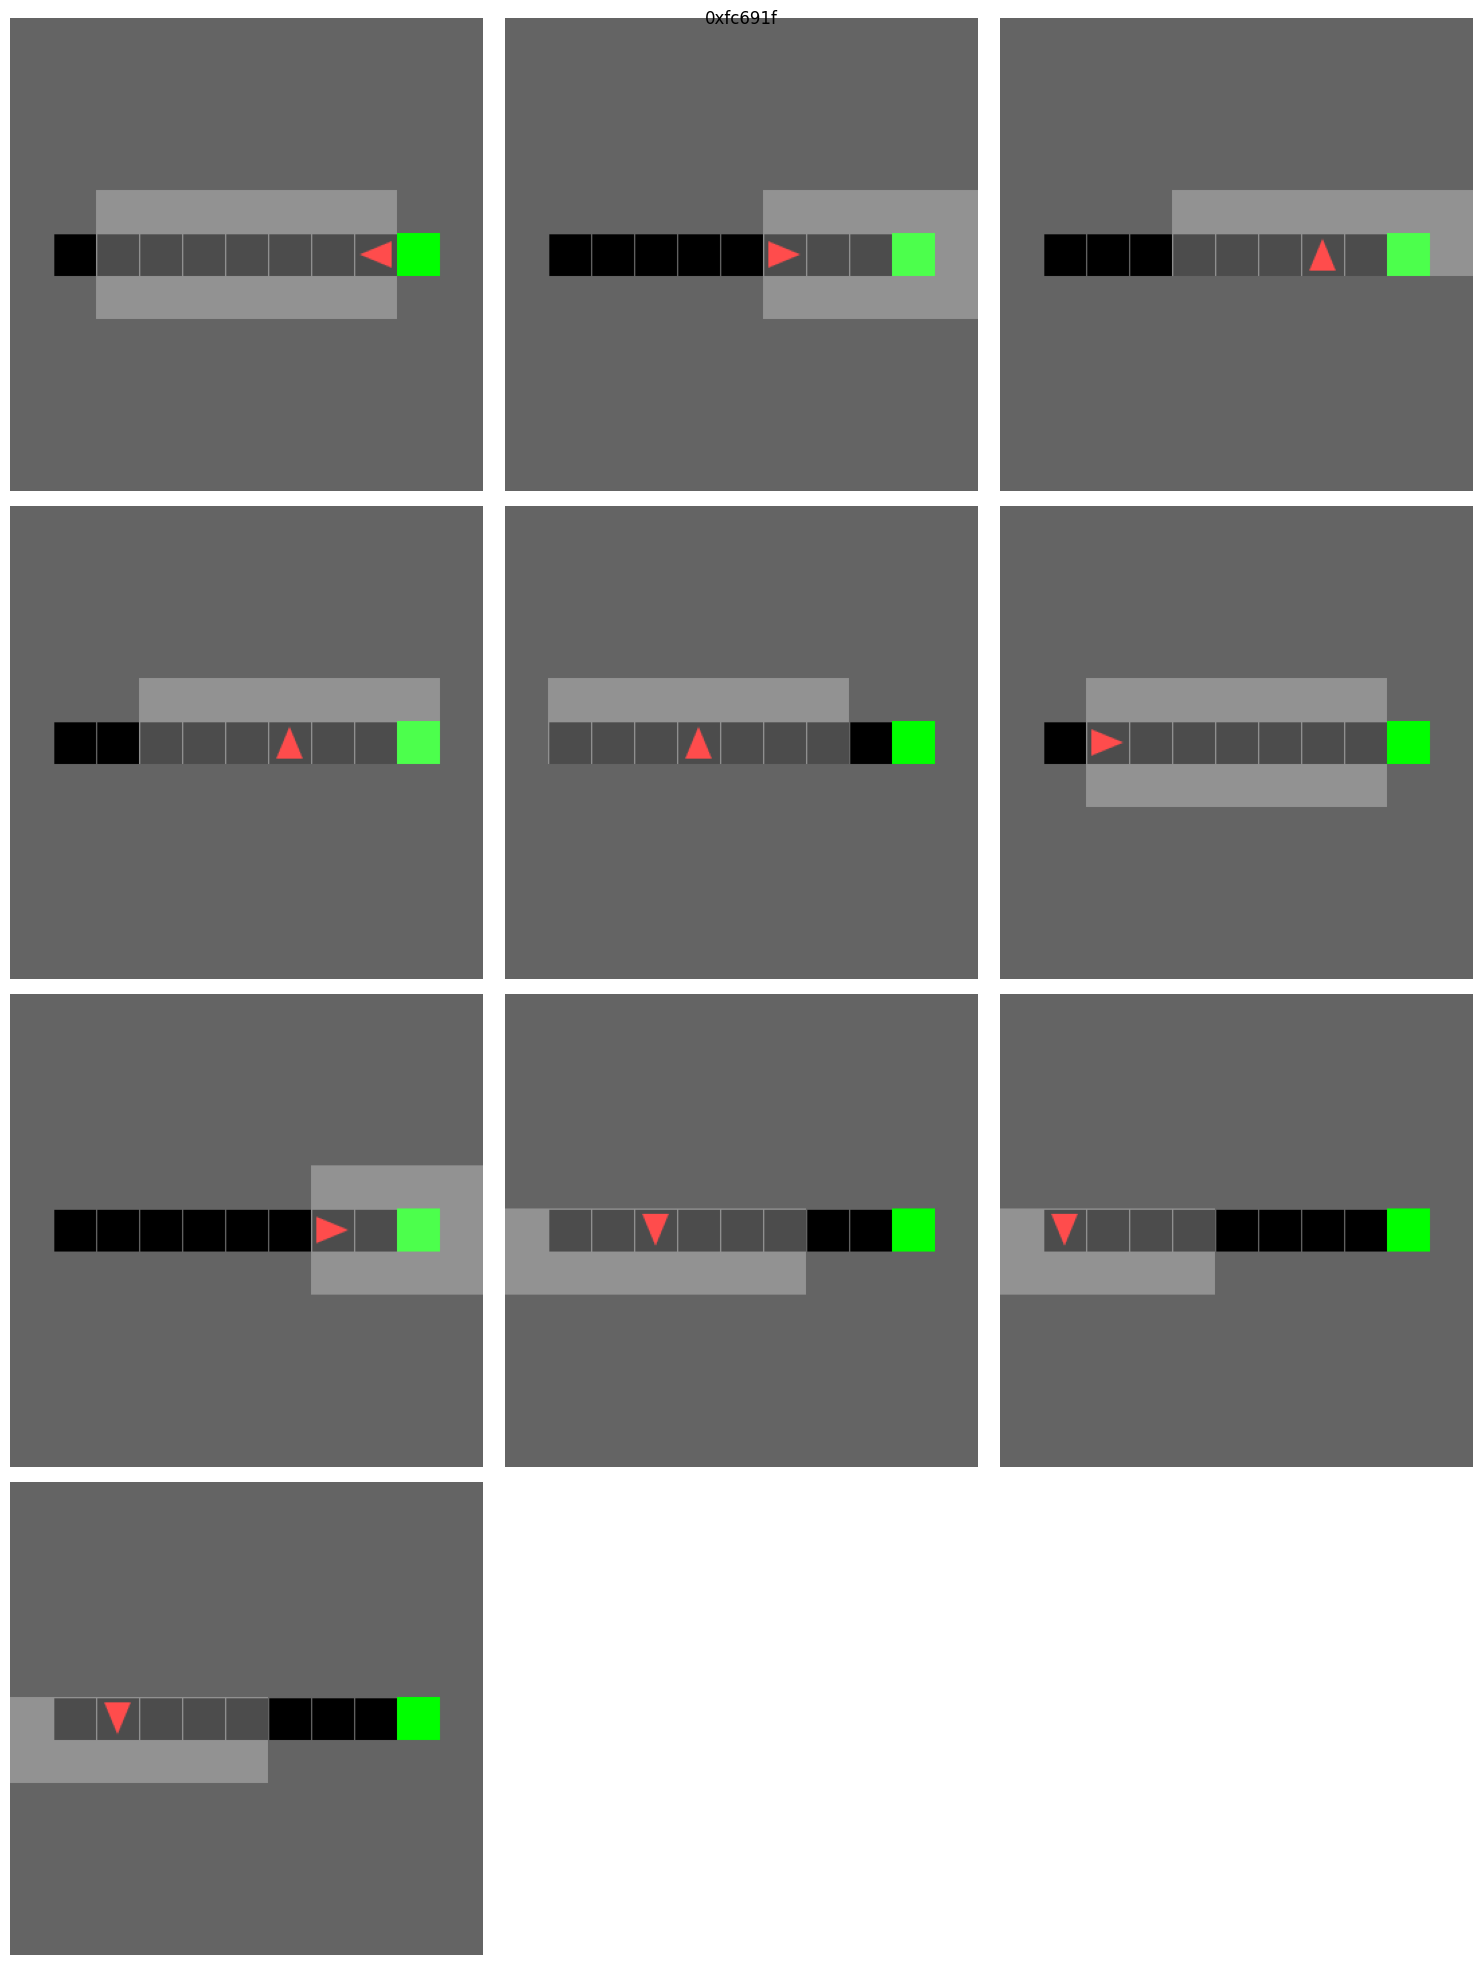

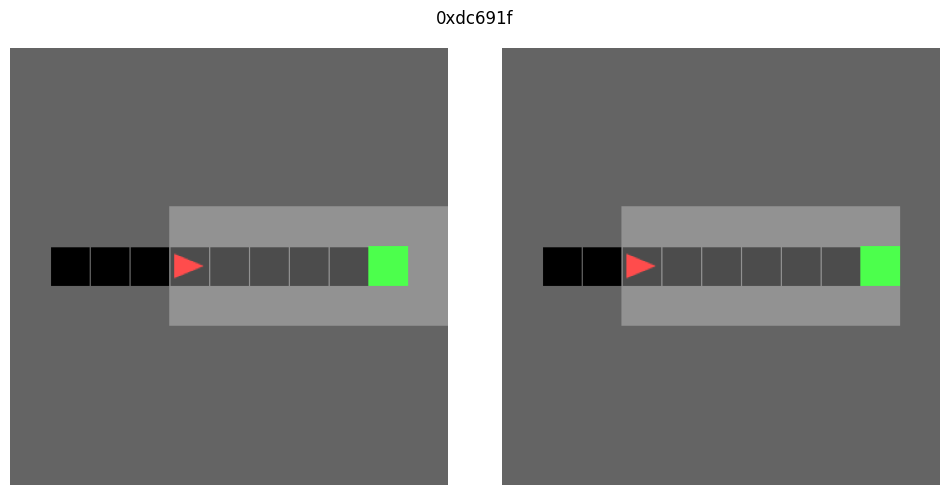

In [9]:
learner = EncodingMDPLearner(env, encoder, device, keep_dims=64)
learner.learn()
optimal_graph = OptimalPolicyGraph()
optimal_graph.load_graph(learner.mdp_graph)
optimal_graph.uniform_prior_policy()
optimal_graph.visualize(highlight_states=[learner.encoded_start_state, *learner.encoded_done_states], use_grid_layout=False, display_state_name=True)

max_cols = 3
for state in learner.encoded_state_set:
    images = learner.encoded_state_to_unencoded_state_dict[state]
    num_images = len(images)
    num_rows = (num_images + max_cols - 1) // max_cols
    num_cols = min(num_images, max_cols)
    plt.figure(figsize=(num_cols * 5, num_rows * 5))
    for i, unencoded in enumerate(images):
        img = learner.unencoded_state_image_dict[unencoded]
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(state)
    plt.tight_layout()
    plt.show()

In [10]:
# learner = EncodingMDPLearner(env, encoder, device, keep_dims=32)
# learner.learn()
# optimal_graph = OptimalPolicyGraph()
# optimal_graph.load_graph(learner.mdp_graph)
# optimal_graph.uniform_prior_policy()
# optimal_graph.visualize(highlight_states=[learner.encoded_start_state, *learner.encoded_done_states], use_grid_layout=False, display_state_name=True)
# 
# max_cols = 3
# for state in learner.encoded_state_set:
#     images = learner.encoded_state_to_unencoded_state_dict[state]
#     num_images = len(images)
#     num_rows = (num_images + max_cols - 1) // max_cols
#     num_cols = min(num_images, max_cols)
#     plt.figure(figsize=(num_cols * 5, num_rows * 5))
#     for i, unencoded in enumerate(images):
#         img = learner.unencoded_state_image_dict[unencoded]
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.suptitle(state)
#     plt.tight_layout()
#     plt.show()

In [11]:
# learner = EncodingMDPLearner(env, encoder, device, keep_dims=48)
# learner.learn()
# optimal_graph = OptimalPolicyGraph()
# optimal_graph.load_graph(learner.mdp_graph)
# optimal_graph.uniform_prior_policy()
# optimal_graph.visualize(highlight_states=[learner.encoded_start_state, *learner.encoded_done_states],
#                         use_grid_layout=False, display_state_name=True)
# 
# max_cols = 3
# for state in learner.encoded_state_set:
#     images = learner.encoded_state_to_unencoded_state_dict[state]
#     num_images = len(images)
#     num_rows = (num_images + max_cols - 1) // max_cols
#     num_cols = min(num_images, max_cols)
#     plt.figure(figsize=(num_cols * 5, num_rows * 5))
#     for i, unencoded in enumerate(images):
#         img = learner.unencoded_state_image_dict[unencoded]
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.suptitle(state)
#     plt.tight_layout()
#     plt.show()

In [12]:
# learner = EncodingMDPLearner(env, encoder, device, keep_dims=64)
# learner.learn()
# optimal_graph = OptimalPolicyGraph()
# optimal_graph.load_graph(learner.mdp_graph)
# optimal_graph.uniform_prior_policy()
# optimal_graph.visualize(highlight_states=[learner.encoded_start_state, *learner.encoded_done_states],
#                         use_grid_layout=False, display_state_name=True)
# 
# max_cols = 3
# for state in learner.encoded_state_set:
#     images = learner.encoded_state_to_unencoded_state_dict[state]
#     num_images = len(images)
#     num_rows = (num_images + max_cols - 1) // max_cols
#     num_cols = min(num_images, max_cols)
#     plt.figure(figsize=(num_cols * 5, num_rows * 5))
#     for i, unencoded in enumerate(images):
#         img = learner.unencoded_state_image_dict[unencoded]
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.suptitle(state)
#     plt.tight_layout()
#     plt.show()